In [1]:
import sys
sys.path.append('../..')

You can download Land-Use Scene Classification dataset [here](https://www.kaggle.com/datasets/mdwaquarazam/agricultural-crops-image-classification).
The first step is to prepare the dataset in the pytorch Dataset format.

In [2]:
import torch
from torch.utils.data import random_split
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder


dataset_path = '/media/n31v/data/datasets/Agricultural-crops/'

transform = Compose([ToTensor(), Resize((500, 500))])
dataset = ImageFolder(root=dataset_path, transform=transform)
samples = len(dataset)
train_samples = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(
    dataset,
    [train_samples, samples - train_samples],
    generator=torch.Generator().manual_seed(31)
)

In the cell below, we define the parameters of the experiments to be carried out: an experiment without structure optimization, experiments with a singular value decomposition of convolutional layers, and experiments with soft filter pruning.

If you want to use a pre-trained model, you can set weights parameter like `weights=<your path to state dict>`.

If you don't want to reproduce experiments, you can skip this cell.

In [ ]:
energy_thresholds = [
    0.1, 0.3, 0.5, 0.7, 0.9,
    0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
    0.992, 0.994, 0.996, 0.998, 0.999,
    0.9999, 1
]
optimizations = {
    'none': [{}],
    'SVD': [
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
    ],
    'SFP': [
        {
            'pruning_ratio': 0.5,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.7,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.8,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.9,
            'finetuning_epochs': 5
        },
    ]
}

In the cell below, we run experiments for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

import torch
from core.operation.utils.cv_experimenters import ClassificationExperimenter


for optimization, params_list in optimizations.items():
    for params in params_list:
        experimenter = ClassificationExperimenter(
            dataset_name='Agricultural-crops',
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            num_classes=30,
            dataloader_params={'batch_size': 32, 'num_workers': 4},
            model='ResNet18',
            model_params={},
            models_saving_path='models',
            optimizer=torch.optim.Adam,
            optimizer_params={},
            target_loss=torch.nn.CrossEntropyLoss,
            loss_params={},
            target_metric='f1',
            structure_optimization=optimization,
            structure_optimization_params=params,
            summary_path='runs',
            summary_per_class=True,
            gpu=True
        )
        experimenter.fit(100)

If you want to use our trained model, you can use the code from the cell below.

In [7]:
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from core.operation.utils.svd_tools import load_svd_state_dict
from core.operation.utils.sfp_tools import load_sfp_rsnet_model

dl = DataLoader(dataset, batch_size=8, shuffle=True)

state_dict_path = 'models/Agricultural-crops/ResNet18_SVD_channel_O-100.0_H-0.001000/fine-tuning_e_0.999.sd.pt'
svd_model = resnet18(num_classes=30)
load_svd_state_dict(svd_model, decomposing_mode='channel', state_dict_path=state_dict_path)

sfp_state_dict_path = 'models/Agricultural-crops/ResNet18_SFP_P-0.50/fine-tuning.sd.pt'
sfp_model = load_sfp_rsnet_model('ResNet18', num_classes=30, state_dict_path=sfp_state_dict_path, pruning_ratio=0.5)


images, targets = next(iter(dl))
svd_preds = svd_model(images)
sfp_preds = sfp_model(images)
print(f'target:\t\t\t{targets}\nSVD prediction: {svd_preds.argmax(1)}\nSFP prediction: {sfp_preds.argmax(1)}')

target:			tensor([24, 18,  7, 29,  7, 17, 24, 29])
SVD prediction: tensor([24, 18,  7, 29,  7, 17,  3, 29])
SFP prediction: tensor([24, 16,  7,  9,  1, 19,  0, 29])


Top models by f1 metric.

In [9]:
from visualization_utils import parse_experiment_folder

train_scores, svd_scores, sfp_scores = parse_experiment_folder('runs/Agricultural-crops')
train_scores['val/f1'].max(axis=0).sort_values(ascending=False)

ResNet18_SVD_channel_O-100.0_H-0.001000    0.623933
ResNet18_SVD_spatial_O-100.0_H-0.001000    0.590164
ResNet18                                   0.502358
ResNet18_SVD_spatial_O-10.0_H-0.001000     0.486925
ResNet18_SVD_channel_O-10.0_H-0.001000     0.411508
ResNet18_SFP_P-0.50                        0.376938
ResNet18_SFP_P-0.70                        0.216799
ResNet18_SFP_P-0.80                        0.012381
ResNet18_SFP_P-0.90                        0.006274
dtype: float64

Run the next cell to visualize the results.

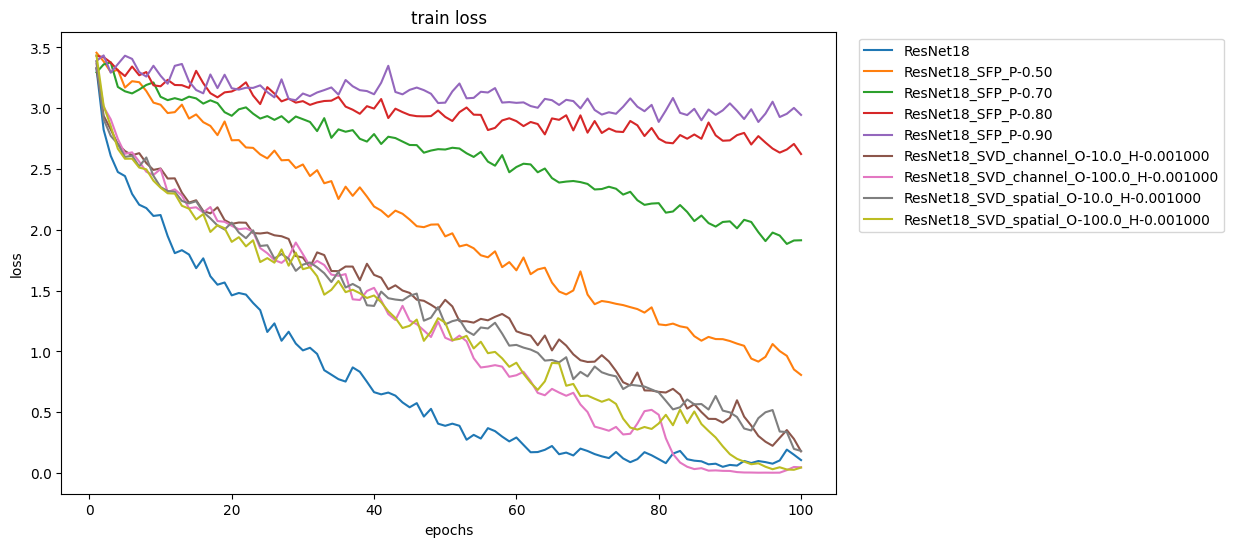

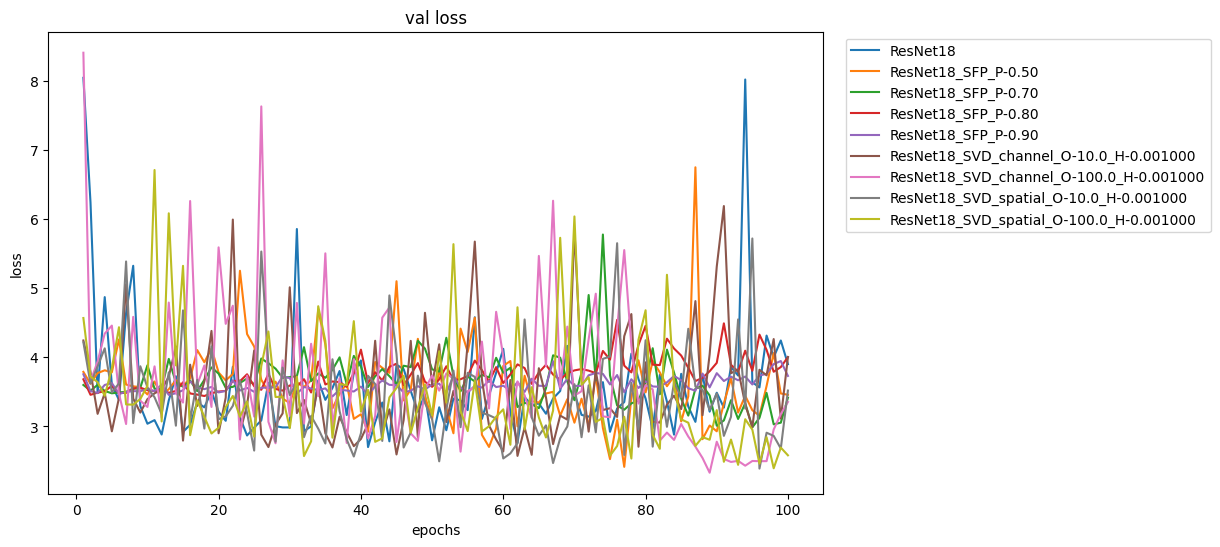

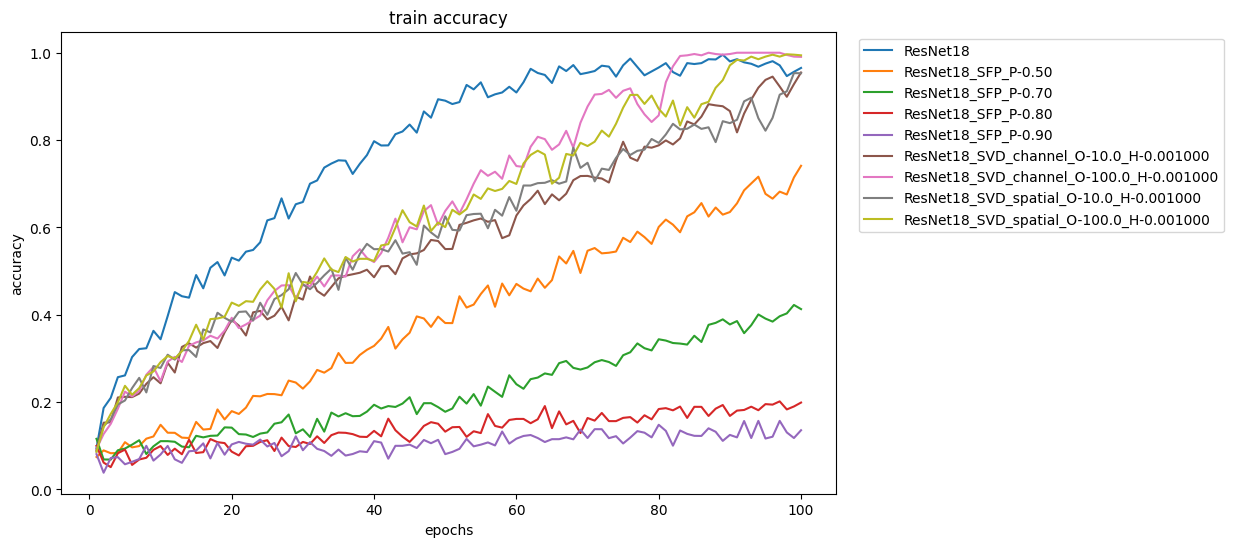

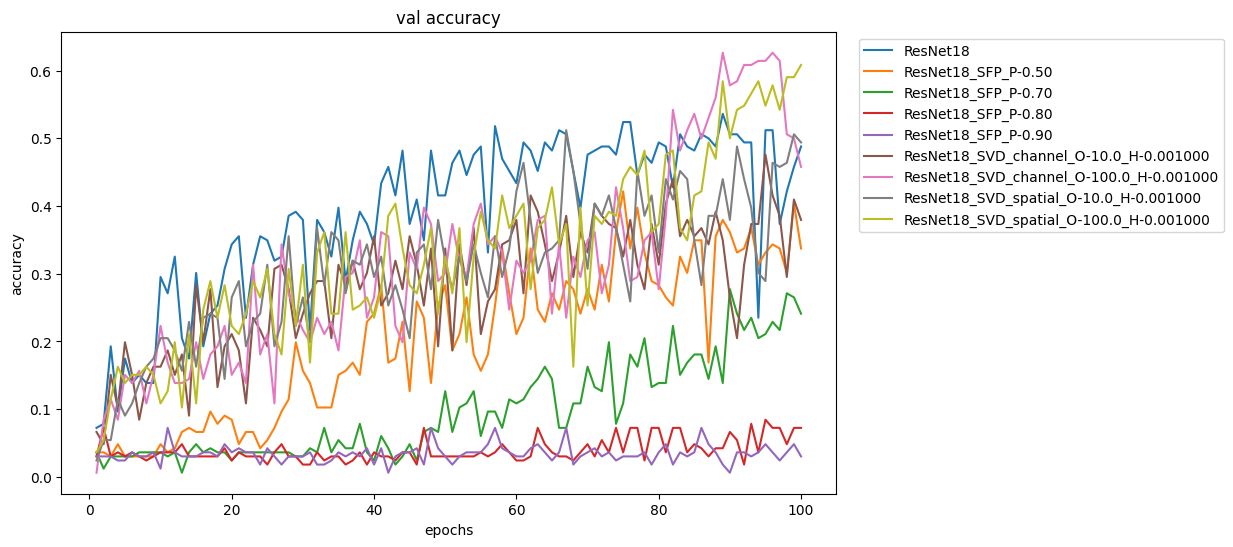

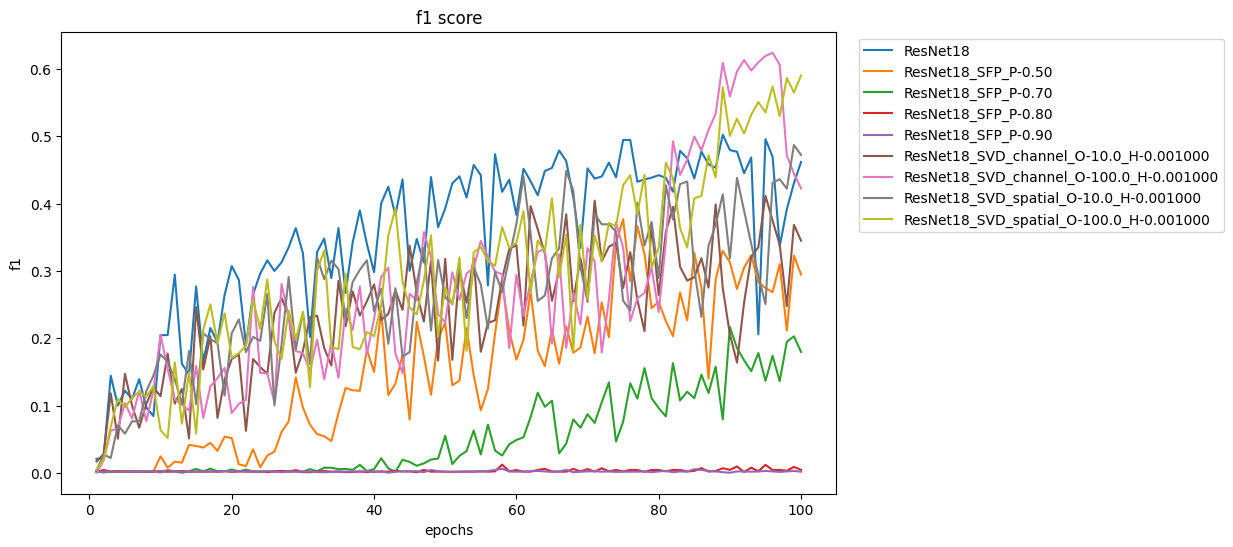

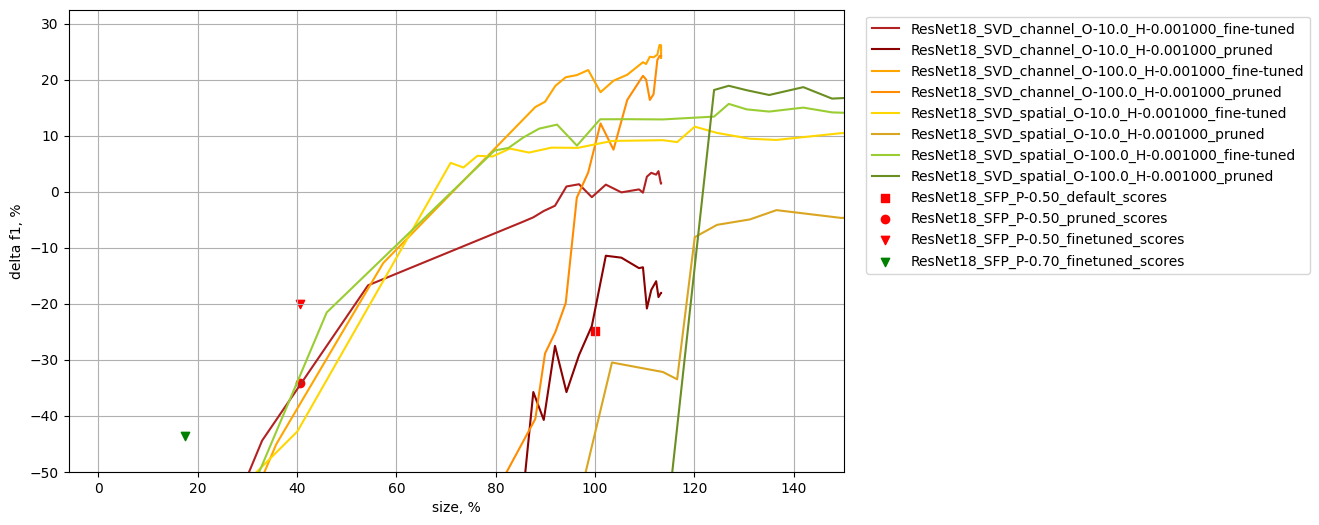

In [10]:
from visualization_utils import draw_results

draw_results('runs/Agricultural-crops', baseline='ResNet18', min_y=-50, max_x=150)

The first five graphs show the values of the metrics during the training process until the final model pruning.

The last graph shows the dependence of the loss in the target metric on the change in the size of the model. The $y$ value is calculated as $\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$ and the $x$ value as $\frac{size_{model} }{size_{baseline}}$.

 Models trained using soft filter pruning optimization can be pruned in the only way. A square marker indicates the state of the model immediately after training, a round marker indicates the state after pruning. The quality loss is due to the presence of BachNorm layers in the ResNet architecture. However, additional training for 5 epochs leads not only to compensation for losses, but also to an increase in the value of the target metric.

Models trained using singular value decomposition optimization can be pruned in a variety of ways, so that an acceptable trade-off can be found between loss of recognition quality and model size. Fine-tuning of pruned models also leads to an increase in the value of the target score. The larger percentage of pruning, the more effective the fine-tuning.

In a problem with a lack of training data, the problem of overfitting comes to the fore. In such problems, the training of decomposed layers demonstrates the best generalizing qualities and the absence of overfitting.